In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import integrate, optimize, stats


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 3125
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [3]:


# Define PDFs
def bimodal_pdf_unnorm(x, A=0.1):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    return torch.exp(-1/A * (-x**2/2 + x**4/4))

def normal_pdf(x, sigma=1.0):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    return (1 / (sigma * np.sqrt(2 * np.pi))) * torch.exp(-x**2/(2*sigma**2))

def compute_Z(A):
    integrand = lambda x: np.exp(-1/A * (-x**2/2 + x**4/4))
    result, _ = integrate.quad(integrand, -10, 10) 
    return result

def calculate_M(sigma, A, Z):
    x_vals = np.linspace(-10, 10, 10000)  
    bimodal_unnorm = np.exp(-1/A * (-x_vals**2/2 + x_vals**4/4))
    bimodal = bimodal_unnorm / Z
    normal = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-x_vals**2/(2*sigma**2))
    
    # Handle potential division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios = np.where(normal > 1e-10, bimodal / normal, 0)
    
    return np.max(ratios) * 1.01  # Add 1% safety margin

def find_optimal_sigma(A, Z):

    def objective(sigma):
            return calculate_M(sigma[0], A, Z)
    
    bounds = [(0.1, 5.0)] 
    initial_guess = [1.0]
    
    result = optimize.minimize(
        objective, 
        initial_guess, 
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    optimal_sigma = result.x[0]
    return optimal_sigma

In [4]:
def create_bimodal_samples_flat(batch_size = 4000, A=0.05):
    Z = compute_Z(A)
    sigma = find_optimal_sigma(A, Z)
    M = calculate_M(sigma, A, Z)

    num_samples = batch_size
    
    accepted_samples = torch.zeros(num_samples, 1).to(device)
    accepted_count = 0
    total_iterations = 0
    max_iterations = 1000000 
    
    start_time = time.time()
    
    # Main acceptance-rejection loop
    while accepted_count < num_samples and total_iterations < max_iterations:
        # Generate proposal samples from normal distribution
        proposal_batch_size = min(batch_size, num_samples - accepted_count)
        normal_samples = np.random.normal(0, sigma, size=proposal_batch_size).astype(np.float32)
        proposal_samples = torch.tensor(normal_samples).unsqueeze(1).to(device)
        
        # Generate uniform samples for acceptance test
        uni_acceptance = np.random.uniform(low=0, high=1, size=proposal_batch_size).astype(np.float32)
        uni_acceptance = torch.tensor(uni_acceptance).unsqueeze(1).to(device)
        
        # Compute bimodal density of proposal
        bimodal_density = bimodal_pdf_unnorm(proposal_samples, A=A) / Z
        
        # Compute proposal density
        prop_density = normal_pdf(proposal_samples, sigma=sigma)
        
        # Compute acceptance probability
        acceptance_ratio = bimodal_density / (M * prop_density)
        
        # Accept samples where uni_acceptance <= acceptance_ratio
        accept_mask = (uni_acceptance <= acceptance_ratio).squeeze()
        
        if accept_mask.sum() > 0:
            num_accepted_batch = min(accept_mask.sum().item(), num_samples - accepted_count)
            accepted_samples[accepted_count:accepted_count + num_accepted_batch] = \
                proposal_samples[accept_mask][:num_accepted_batch]
            accepted_count += num_accepted_batch
        
        total_iterations += proposal_batch_size
        
        if total_iterations % 10000 == 0:
            print(f'Iterations: {total_iterations}, Accepted: {accepted_count}/{num_samples}, ' 
                  f'Efficiency: {100 * accepted_count / total_iterations:.2f}%')
    
    elapsed_time = time.time() - start_time
    efficiency = 100 * accepted_count / total_iterations
    
    print(f"Bimodal sampling completed in {elapsed_time:.2f} seconds.")
    print(f"Generated {accepted_count} samples from {total_iterations} proposal samples.")
    print(f"Acceptance efficiency: {efficiency:.2f}%")
    print(f"Theoretical acceptance rate: {100/M:.2f}%")
    
    bimodal_samples = accepted_samples.cpu().numpy()
    return bimodal_samples.flatten()

Bimodal sampling completed in 0.01 seconds.
Generated 4000 samples from 20276 proposal samples.
Acceptance efficiency: 19.73%
Theoretical acceptance rate: 19.75%


Text(0, 0.5, 'Density')

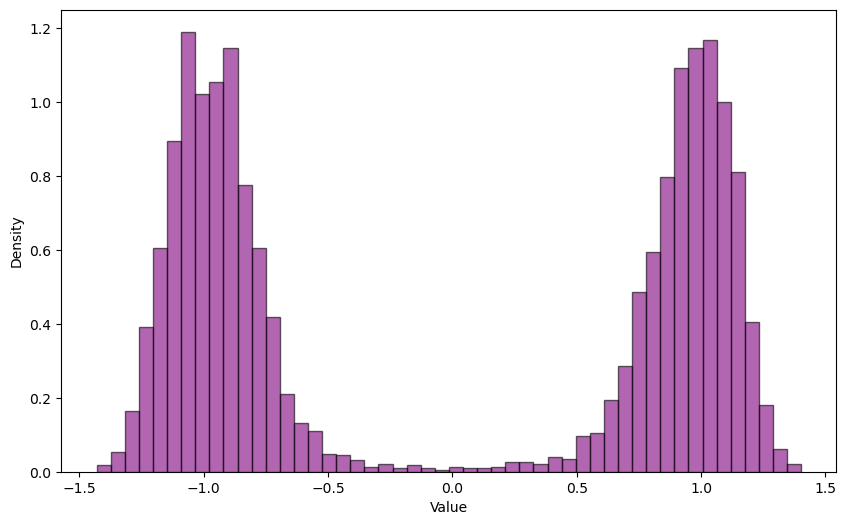

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(create_bimodal_samples_flat(), bins=50, density=True, alpha=0.6, color='purple', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Density')

In [6]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
class PDFLoss(nn.Module):
    def __init__(self, target_tensor, bw=0.02, n_bins=300, hist_weight=1, moment_weight=1):  
        super(PDFLoss, self).__init__()
        self.bw = bw
        self.n_bins = int(n_bins)
        self.hist_weight = hist_weight
        self.moment_weight = moment_weight
        
        self.target_tensor = target_tensor
        
        self.target_mean = torch.mean(target_tensor)
        self.target_std = torch.std(target_tensor)
        
        # Create normalized target 
        self.normalized_target = self._normalize_data(target_tensor)
        
        # Set fixed range for normalized space
        self.norm_min_val = -5
        self.norm_max_val = 5
        
        # Precompute target moments in normalized space
        target_flat_norm = self.normalized_target.view(-1)
        self.target_moments = self._compute_higher_moments(target_flat_norm)
        
        # Create evaluation points and precompute target KDE in normalized space
        self.eval_points = torch.linspace(self.norm_min_val, self.norm_max_val, 
                                          self.n_bins).to(target_tensor.device)
        self.target_density = self._kde(target_flat_norm, self.eval_points)
    
    def _normalize_data(self, data):
        # Normalize to have mean=0 and std=1
        return (data - self.target_mean) / self.target_std
    
    def _compute_higher_moments(self, x):
        mean = torch.mean(x)
        std = torch.std(x)

        moments = []
        for i in range(1, 8):
            moments.append(torch.mean(((x - mean) / std) ** i))
    
        return moments
    
    def _kde(self, samples, eval_points):
        samples = samples.view(-1, 1)
        eval_points = eval_points.view(-1, 1)
        
        # Calculate pairwise distances
        dist = eval_points - samples.t()
        
        # Apply Gaussian kernel
        weights = torch.exp(-0.5 * (dist / self.bw)**2) / (self.bw * np.sqrt(2 * np.pi))
        
        # Average over samples
        density = weights.mean(dim=1)
        return density
    
    def _histogram_loss(self, normalized_pred):
        # Compute histograms
        pred_hist = torch.histc(normalized_pred.flatten(), bins=self.n_bins, 
                               min=self.norm_min_val, max=self.norm_max_val)
        
        target_hist = torch.histc(self.normalized_target.flatten(), bins=self.n_bins, 
                                 min=self.norm_min_val, max=self.norm_max_val)
        
        # Normalize histograms
        pred_hist = pred_hist / torch.sum(pred_hist)
        target_hist = target_hist / torch.sum(target_hist)
        
        # Return L1 loss between histograms
        return torch.mean(torch.abs(pred_hist - target_hist))**1
    
    def _moment_loss(self, normalized_pred_flat):
        # Compute higher moments (up to 8th moment)
        pred_moments = self._compute_higher_moments(normalized_pred_flat)
        
        total_moment_loss = 0.0
        moment_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  # Weights for moments 1-8
        
        for i in range(len(pred_moments)):
            moment_loss = torch.abs(pred_moments[i] - self.target_moments[i])
            total_moment_loss += moment_weights[i] * moment_loss
        
        return total_moment_loss
    
    def forward(self, pred_samples):
        # Normalize predictions for PDF calculations
        normalized_pred = self._normalize_data(pred_samples)
        pred_flat_norm = normalized_pred.view(-1)
        
        # KDE-based loss in normalized space
        pred_density = self._kde(pred_flat_norm, self.eval_points)
        kde_loss = torch.mean((pred_density - self.target_density)**2)
        
        # Histogram-based loss in normalized space
        hist_loss = self._histogram_loss(normalized_pred)
        
        # Moment-based loss in normalized space
        moment_loss = self._moment_loss(pred_flat_norm)
        
        # Combined loss
        print(f"KDE loss: {kde_loss.item():.4f}, Hist loss: {(self.hist_weight * hist_loss).item():.4f}, Moment loss: {(self.moment_weight * moment_loss).item():.4f}")
        total_loss = kde_loss + self.hist_weight * hist_loss + self.moment_weight * moment_loss

        return total_loss

In [8]:
# Generate sample data
batch_size = 10000

# Generate uniform samples
uniform_samples = np.random.uniform(low=0, high=1, size=batch_size).astype(np.float32)

# Generate bimodal samples
bimodal_samples = create_bimodal_samples_flat(batch_size)
# bimodal_samples = bimodal_samples + 10

# Convert to tensors
uni_input = torch.from_numpy(uniform_samples.reshape(batch_size, 1)).to(device)
# target = torch.from_numpy(bimodal_samples.reshape(batch_size, 1)).to(device)
target = torch.from_numpy(bimodal_samples.reshape(batch_size)).to(device)




Iterations: 10000, Accepted: 1983/10000, Efficiency: 19.83%
Bimodal sampling completed in 0.01 seconds.
Generated 10000 samples from 50238 proposal samples.
Acceptance efficiency: 19.91%
Theoretical acceptance rate: 19.75%


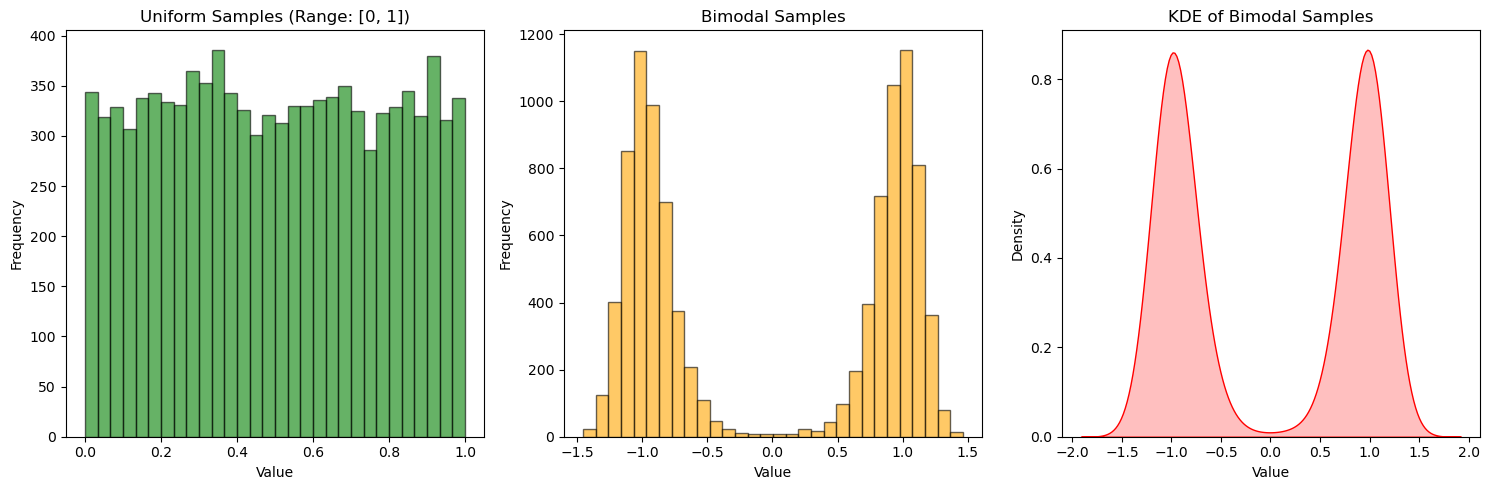

In [9]:
# Visualize input and target distributions
plt.figure(figsize=(15, 5))

# Plot uniform distribution
plt.subplot(1, 3, 1)
plt.hist(uniform_samples, bins=30, alpha=0.6, color='green', edgecolor='black')
plt.title('Uniform Samples (Range: [0, 1])')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot bimodal distribution
plt.subplot(1, 3, 2)
plt.hist(bimodal_samples, bins=30, alpha=0.6, color='orange', edgecolor='black')
plt.title('Bimodal Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot density
plt.subplot(1, 3, 3)
sns.kdeplot(bimodal_samples, color='red', fill=True)
plt.title('KDE of Bimodal Samples')
plt.xlabel('Value')
plt.tight_layout()
plt.show()

In [10]:
n_bins = int(20 * batch_size**(1/5)) # Number of bins for histogram loss function
bw = 0.05 * batch_size ** (-1/5) # Bandwidth for kde

loss_function = PDFLoss(
    target, bw=bw, 
    n_bins=n_bins,
    hist_weight=100,
    moment_weight=.1)

# Initialize the neural network
model = FNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_list = []
epoch_list = []

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):

    normalized_outputs = model(uni_input)
    
    # Denormalize
    outputs = normalized_outputs * loss_function.target_std + loss_function.target_mean
    
    loss = loss_function(outputs)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss and epoch number
    loss_list.append(loss.item())
    epoch_list.append(epoch + 1)
    
    # Logging every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
    
    # Early stopping condition
    if loss.item() <= 0.000005:
        print(f"Early stopping at epoch {epoch+1} with loss {loss.item():.8f}")
        break

KDE loss: 1.2546, Hist loss: 1.5849, Moment loss: 0.3097
KDE loss: 4.7034, Hist loss: 1.5814, Moment loss: 1.7293
KDE loss: 0.7191, Hist loss: 1.5789, Moment loss: 0.5354
KDE loss: 0.4185, Hist loss: 1.5684, Moment loss: 0.4179
KDE loss: 0.3082, Hist loss: 1.5679, Moment loss: 0.3709
KDE loss: 0.2801, Hist loss: 1.5670, Moment loss: 0.3436
KDE loss: 0.2479, Hist loss: 1.5659, Moment loss: 0.3233
KDE loss: 0.2318, Hist loss: 1.5648, Moment loss: 0.3057
KDE loss: 0.2210, Hist loss: 1.5648, Moment loss: 0.2971
KDE loss: 0.2056, Hist loss: 1.5641, Moment loss: 0.3115
KDE loss: 0.2036, Hist loss: 1.5621, Moment loss: 0.3223
KDE loss: 0.1935, Hist loss: 1.5621, Moment loss: 0.3304
KDE loss: 0.2014, Hist loss: 1.5621, Moment loss: 0.3348
KDE loss: 0.1871, Hist loss: 1.5589, Moment loss: 0.3376
KDE loss: 0.1881, Hist loss: 1.5589, Moment loss: 0.3393
KDE loss: 0.1912, Hist loss: 1.5589, Moment loss: 0.3396
KDE loss: 0.1835, Hist loss: 1.5533, Moment loss: 0.3390
KDE loss: 0.1756, Hist loss: 1.

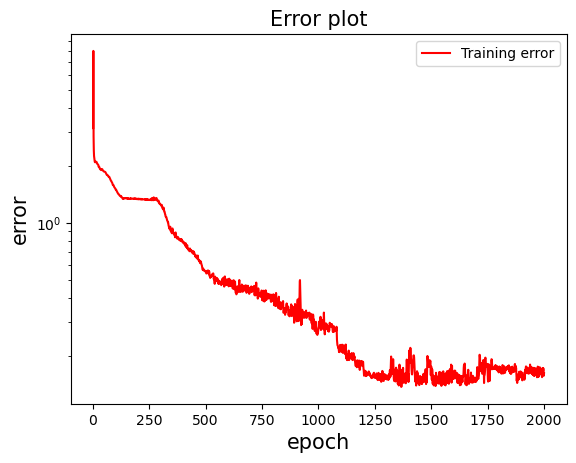

In [11]:
# Plot loss curve
plt.figure()
plt.title("Error plot", fontsize=15) 
plt.yscale('log')
plt.plot(epoch_list, loss_list, 'r', label='Training error')
plt.xlabel('epoch', fontsize=15)
plt.ylabel('error', fontsize=15)
plt.legend()
plt.show()

In [12]:
# Test the transformation
seed = 3126
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
with torch.no_grad():
    # Generate new uniform samples for testing
    test_uniform = np.random.uniform(low=0, high=1, size=batch_size).astype(np.float32)
    test_input = torch.from_numpy(test_uniform.reshape(batch_size, 1)).to(device)
    
    # Transform samples using the trained model
    transformed_samples = model(test_input)* loss_function.target_std + loss_function.target_mean


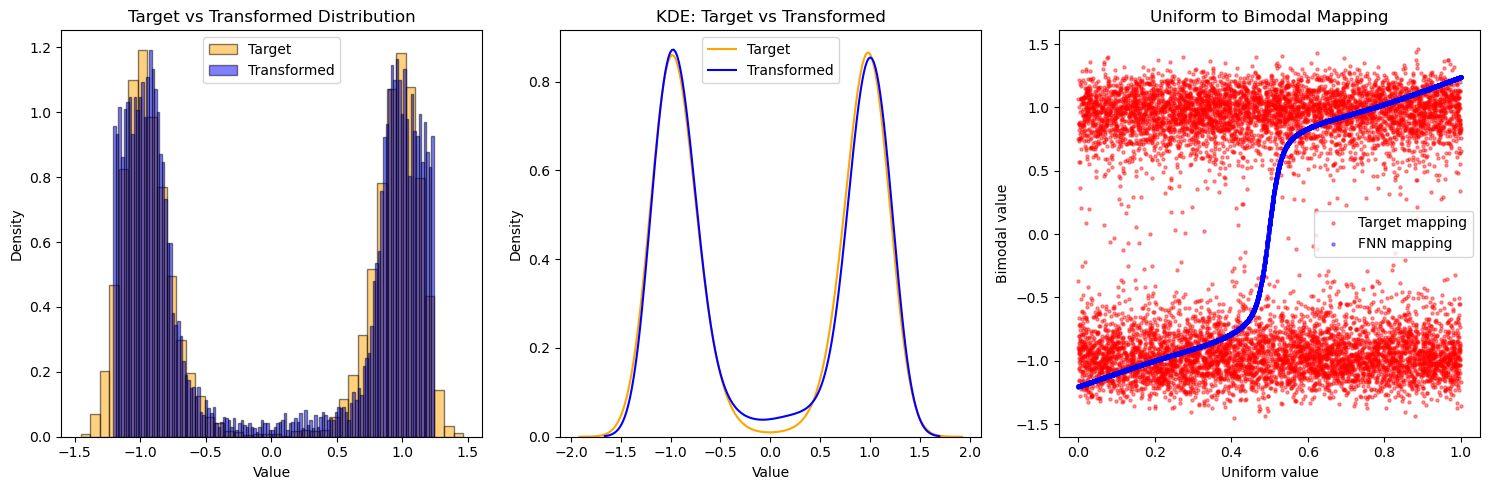

Batch size: 10000
Bandwidth: 0.007924465962305567
Number of bins: 126


In [13]:
# Plot the comparison between target and transformed distributions
plt.figure(figsize=(15, 5))

# Histogram comparison
plt.subplot(1, 3, 1)
plt.hist(bimodal_samples, bins=40, alpha=0.5, density=True, color='orange', 
         edgecolor='black', label='Target')
plt.hist(transformed_samples.cpu().numpy().flatten(), bins=int(n_bins), alpha=0.5, 
         density=True, color='blue', edgecolor='black', label='Transformed')
plt.title('Target vs Transformed Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# KDE comparison
plt.subplot(1, 3, 2)
sns.kdeplot(bimodal_samples, color='orange', label='Target')
sns.kdeplot(transformed_samples.cpu().numpy().flatten(), color='blue', label='Transformed')
plt.title('KDE: Target vs Transformed')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Scatter plot of mapping
plt.subplot(1, 3, 3)
plt.scatter(uniform_samples, bimodal_samples, c='r', s=5, alpha=0.4, label='Target mapping')
plt.scatter(test_uniform, transformed_samples.cpu().numpy().flatten(), 
           c='b', s=5, alpha=0.4, label='FNN mapping')
plt.title('Uniform to Bimodal Mapping')
plt.xlabel('Uniform value')
plt.ylabel('Bimodal value')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Batch size: {batch_size}")
print(f"Bandwidth: {bw}")
print(f"Number of bins: {n_bins}")

# poisson

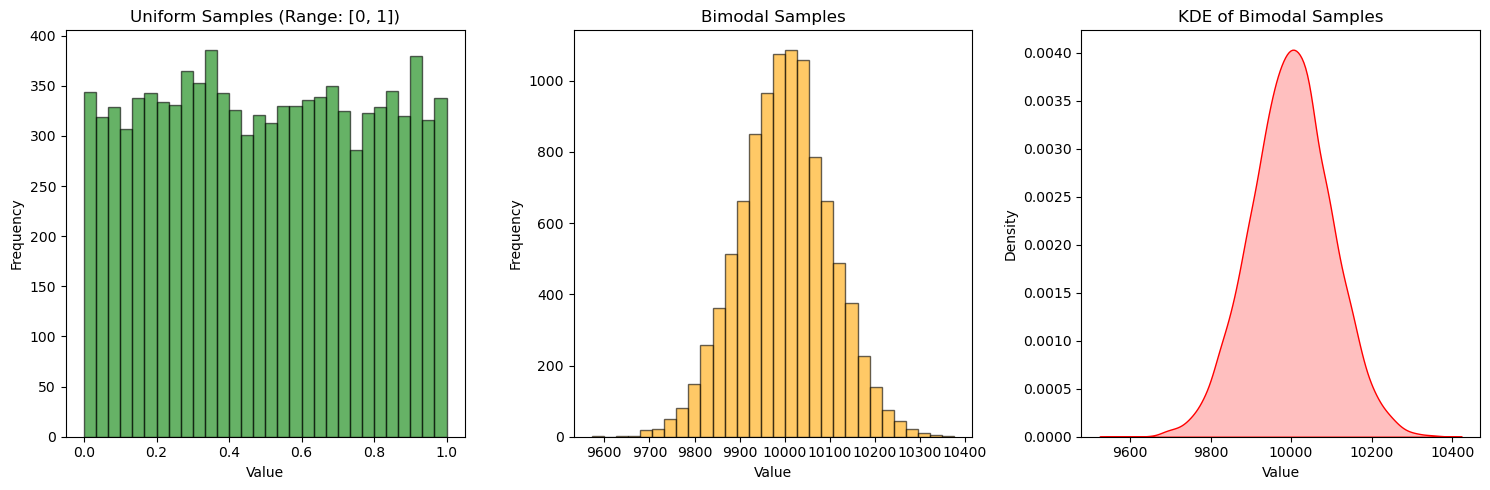

In [77]:
# Generate Poisson samples with lambda = 100
poisson_samples = np.random.poisson(lam=10000, size=batch_size).astype(np.float32)

# Convert to tensor (using same shape as your target)
target = torch.from_numpy(poisson_samples.reshape(batch_size)).to(device)
# Visualize input and target distributions
plt.figure(figsize=(15, 5))

# Plot uniform distribution
plt.subplot(1, 3, 1)
plt.hist(uniform_samples, bins=30, alpha=0.6, color='green', edgecolor='black')
plt.title('Uniform Samples (Range: [0, 1])')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot bimodal distribution
plt.subplot(1, 3, 2)
plt.hist(poisson_samples, bins=30, alpha=0.6, color='orange', edgecolor='black')
plt.title('Bimodal Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot density
plt.subplot(1, 3, 3)
sns.kdeplot(poisson_samples, color='red', fill=True)
plt.title('KDE of Bimodal Samples')
plt.xlabel('Value')
plt.tight_layout()
plt.show()

In [78]:
n_bins = int(25 * batch_size**(1/5)) # Number of bins for histogram loss function
bw = 0.05 * batch_size ** (-1/5) # Bandwidth for kde

loss_function = PDFLoss(
    target, bw=bw, 
    n_bins=n_bins,
    hist_weight=300,
    moment_weight=.01)

# Initialize the neural network
model = FNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_list = []
epoch_list = []

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):

    normalized_outputs = model(uni_input)
    
    # Denormalize
    outputs = normalized_outputs * loss_function.target_std + loss_function.target_mean
    
    loss = loss_function(outputs)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss and epoch number
    loss_list.append(loss.item())
    epoch_list.append(epoch + 1)
    
    # Logging every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
    
    # Early stopping condition
    if loss.item() <= 0.000005:
        print(f"Early stopping at epoch {epoch+1} with loss {loss.item():.8f}")
        break

KDE loss: 1.2657, Hist loss: 3.6294, Moment loss: 0.1546
KDE loss: 0.4116, Hist loss: 3.4494, Moment loss: 0.1424
KDE loss: 0.3140, Hist loss: 3.4429, Moment loss: 0.1482
KDE loss: 0.3175, Hist loss: 3.4292, Moment loss: 0.1558
KDE loss: 0.3377, Hist loss: 3.4903, Moment loss: 0.1625
KDE loss: 0.3106, Hist loss: 3.5270, Moment loss: 0.1657
KDE loss: 0.2126, Hist loss: 3.5599, Moment loss: 0.1657
KDE loss: 0.2202, Hist loss: 3.5962, Moment loss: 0.1649
KDE loss: 0.1788, Hist loss: 3.6023, Moment loss: 0.1638
KDE loss: 0.2001, Hist loss: 3.6539, Moment loss: 0.1632
KDE loss: 0.1698, Hist loss: 3.6390, Moment loss: 0.1619
KDE loss: 0.1763, Hist loss: 3.6585, Moment loss: 0.1611
KDE loss: 0.1589, Hist loss: 3.6726, Moment loss: 0.1604
KDE loss: 0.1476, Hist loss: 3.6684, Moment loss: 0.1596
KDE loss: 0.1350, Hist loss: 3.6650, Moment loss: 0.1591
KDE loss: 0.1325, Hist loss: 3.6848, Moment loss: 0.1589
KDE loss: 0.1245, Hist loss: 3.6833, Moment loss: 0.1586
KDE loss: 0.1206, Hist loss: 3.

In [79]:
# Test the transformation
seed = 3125
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
with torch.no_grad():
    # Generate new uniform samples for testing
    test_uniform = np.random.uniform(low=0, high=1, size=batch_size).astype(np.float32)
    test_input = torch.from_numpy(test_uniform.reshape(batch_size, 1)).to(device)
    
    # Transform samples using the trained model - outputs already in target space
    transformed_samples = model(test_input)* loss_function.target_std + loss_function.target_mean


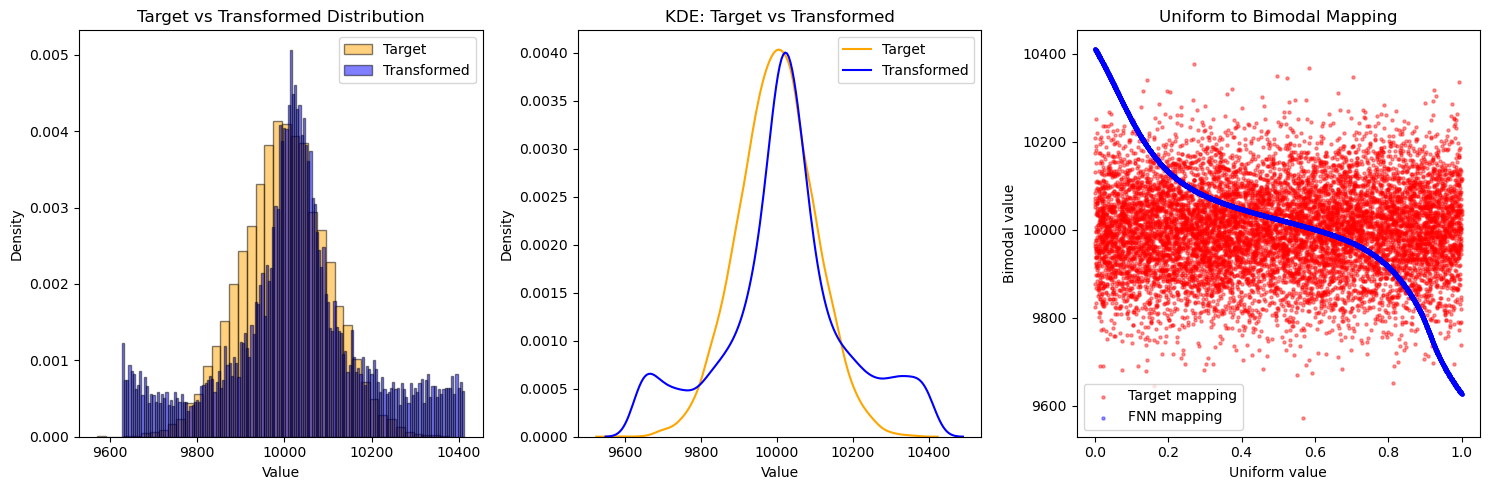

Batch size: 10000
Bandwidth: 0.007924465962305567
Number of bins: 157


In [80]:
# Plot the comparison between target and transformed distributions
plt.figure(figsize=(15, 5))

# Histogram comparison
plt.subplot(1, 3, 1)
plt.hist(poisson_samples, bins=40, alpha=0.5, density=True, color='orange', 
         edgecolor='black', label='Target')
plt.hist(transformed_samples.cpu().numpy().flatten(), bins=int(n_bins), alpha=0.5, 
         density=True, color='blue', edgecolor='black', label='Transformed')
plt.title('Target vs Transformed Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# KDE comparison
plt.subplot(1, 3, 2)
sns.kdeplot(poisson_samples, color='orange', label='Target')
sns.kdeplot(transformed_samples.cpu().numpy().flatten(), color='blue', label='Transformed')
plt.title('KDE: Target vs Transformed')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Scatter plot of mapping
plt.subplot(1, 3, 3)
plt.scatter(uniform_samples, poisson_samples, c='r', s=5, alpha=0.4, label='Target mapping')
plt.scatter(test_uniform, transformed_samples.cpu().numpy().flatten(), 
           c='b', s=5, alpha=0.4, label='FNN mapping')
plt.title('Uniform to Bimodal Mapping')
plt.xlabel('Uniform value')
plt.ylabel('Bimodal value')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Batch size: {batch_size}")
print(f"Bandwidth: {bw}")
print(f"Number of bins: {n_bins}")

In [81]:
print(loss_function.target_mean)

tensor(9999.3975)
